In [16]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd 
import nltk
import enchant
import itertools
import pickle

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Dropout,Flatten
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras_sequential_ascii import keras2ascii
from prettytable import PrettyTable
from keras import metrics
from sklearn.metrics import confusion_matrix

In [17]:
# Load train and test dataset
dataset_dir = os.path.join('docreview')
datasettr = os.path.join(dataset_dir, 'train.csv')
datasetts = os.path.join(dataset_dir, 'test.csv')
print(datasettr)
print(datasetts)

docreview\train.csv
docreview\test.csv


In [18]:
df = pd.read_csv(datasettr)
print('Training dataset')
print(df)

#removing null values
df.dropna(subset=['Review'], inplace=True)
df.dropna(subset=['Rating'], inplace=True)

#removing punctuation
df['Review']=df['Review'].str.replace('[^\w\s]','',regex=True)

#convert to lowercase
df['Review'] = df['Review'].str.lower()

#Removing blank values after preprocessing
df.drop(df.index[df['Review'] == ''], inplace = True)

print('Training dataset after cleaning')
print(df)
df = df[['Review', 'Rating']]
df=df.astype(str)

Training dataset
                                                  Review  Rating
0      It was a very excellent first appointment. Ran...       5
1      I liked Dr. Satsky's bedside manner however  h...       3
2              knowledgeable and not lazy  great doctor!       5
3      Always a pleasant visit with Dr. Maclennan. Sh...       5
4      I've been seeing Dr.Minkowitz for years and ha...       5
...                                                  ...     ...
60542  Excellent visit. Very friendly  competent phys...       5
60543  The absolute best doctor I have been to. She l...       5
60544  Dr. Pate and her staff were excellent! All wer...       5
60545  This place was amazing. It turns out that I cl...       5
60546  I don't have much experience with doctors in m...       5

[60547 rows x 2 columns]
Training dataset after cleaning
                                                  Review  Rating
0      it was a very excellent first appointment ran ...       5
1      i liked 

In [19]:
dfts = pd.read_csv(datasetts)
#removing null values
dfts.dropna(subset=['Review'], inplace=True)
dfts.dropna(subset=['Rating'], inplace=True)
#removing punctuation
dfts['Review']=dfts['Review'].str.replace('[^\w\s]','',regex=True)
#convert to lowercase
dfts['Review'] = dfts['Review'].str.lower()
#Removing blank values after preprocessing
dfts.drop(dfts.index[dfts['Review'] == ''], inplace = True)
print('Testing dataset')
print(dfts)
dfts = dfts[['Review', 'Rating']]
dfts=dfts.astype(str)

Testing dataset
                                                  Review  Rating
0                            very professional  thorough       5
1                                      awesome as usual        5
2                            overall  the visit was ok         4
3      so lovely  personable  kind  attentive i was b...       5
4                           very informative and helpful       5
...                                                  ...     ...
52738  he was greatvery nice and knowledgeable glad t...       5
52739  it was great he made me feel right at home gre...       5
52740  dr raffinan was thorough and attentive as alwa...       5
52741  really fantastic doctor excellent facility and...       5
52742  her bedside manner was great and her staff is ...       5

[52738 rows x 2 columns]


In [20]:
X_train, y_train = df.Review, df.Rating
X_test, y_test = dfts.Review, dfts.Rating
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 60547
# Test data samples: 52738


Training Rating shapes
5 shape= 49447
4 shape= 5335
3 shape= 1723
2 shape= 2123
1 shape= 1919


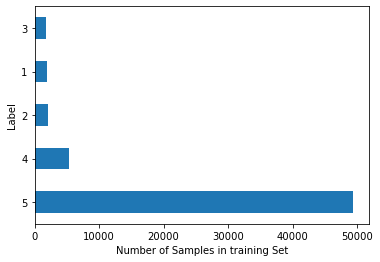

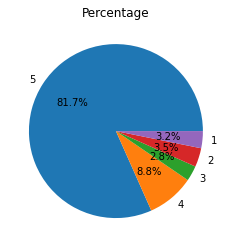

In [21]:
print('Training Rating shapes')
print ('5 shape=',df[df.Rating == '5'].shape[0])
print ('4 shape=',df[df.Rating == '4'].shape[0])
print ('3 shape=',df[df.Rating == '3'].shape[0])
print ('2 shape=',df[df.Rating == '2'].shape[0])
print ('1 shape=',df[df.Rating == '1'].shape[0])

ax = df['Rating'].value_counts(sort=True).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

dfx = [df[df.Rating == '5'].shape[0],df[df.Rating == '4'].shape[0],df[df.Rating == '3'].shape[0],df[df.Rating == '2'].shape[0],df[df.Rating == '1'].shape[0]]
labels = ['5', '4', '3', '2', '1']
figtr, axptr = plt.subplots()
axptr.pie(dfx, autopct="%.1f%%",labels = labels)
axptr.set_title('Percentage')
plt.show()

Rating shapes
5 shape= 43354
4 shape= 4799
3 shape= 1574
2 shape= 1457
1 shape= 1554


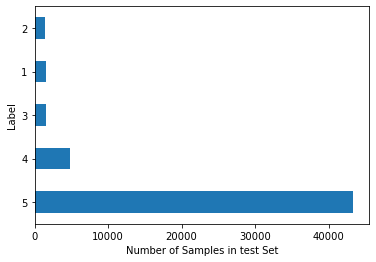

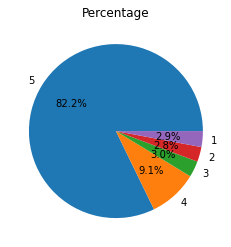

In [22]:
print('Rating shapes')
print ('5 shape=',dfts[dfts.Rating == '5'].shape[0])
print ('4 shape=',dfts[dfts.Rating == '4'].shape[0])
print ('3 shape=',dfts[dfts.Rating == '3'].shape[0])
print ('2 shape=',dfts[dfts.Rating == '2'].shape[0])
print ('1 shape=',dfts[dfts.Rating == '1'].shape[0])

axt = dfts['Rating'].value_counts(sort=True).plot(kind='barh')
axt.set_xlabel("Number of Samples in test Set")
axt.set_ylabel("Label")

dftsx = [dfts[dfts.Rating == '5'].shape[0],dfts[dfts.Rating == '4'].shape[0],dfts[dfts.Rating == '3'].shape[0],dfts[dfts.Rating == '2'].shape[0],dfts[dfts.Rating == '1'].shape[0]]

figts, axpts = plt.subplots()
axpts.pie(dftsx, autopct="%.1f%%",labels = labels)
axpts.set_title('Percentage')
plt.show()

In [23]:
# Tokenization and vectorization
tk = Tokenizer()

tk.fit_on_texts(X_train)
word_index = tk.word_index
word_counts=tk.word_counts

max_review_length=max([len(s.split()) for s in X_train])
print("Maximum review length")
print(max_review_length)

# Saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)


Maximum review length
606


In [24]:
print('Found %s unique tokens.' % len(word_index))
vocab_size = len(word_index) + 1
print(vocab_size)

Found 11547 unique tokens.
11548


In [25]:
# Sequencing
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print(X_train_seq[3])

reconstructed_text = tk.sequences_to_texts(X_train_seq)
print(reconstructed_text[3])

[72, 6, 133, 40, 18, 9, 1143, 14, 10, 202, 1, 134]
always a pleasant visit with dr maclennan she is informative and caring


In [26]:
# truncate and pad input sequences
X_train_trunc = pad_sequences(X_train_seq,  padding='post',maxlen=max_review_length)
X_test_trunc = pad_sequences(X_test_seq,  padding='post',maxlen=max_review_length)
print(X_train_trunc[0])

[  31    5    6    7   65   73   55  997    6 2263 2975   16  201    1
  391    4  160    7  257    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [27]:
# Label encoding
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print(y_test)
print(y_test_oh)

0        5
1        5
2        4
3        5
4        5
        ..
52738    5
52739    5
52740    5
52741    5
52742    5
Name: Rating, Length: 52738, dtype: object
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [28]:
# Splitting training and validation dataset
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_trunc, y_train_oh, test_size=0.3, random_state=42,shuffle=True)
print(X_train_emb)

[[   7 1336  134 ...    0    0    0]
 [  11   10   25 ...    0    0    0]
 [  26    6  124 ...    0    0    0]
 ...
 [   2    5   28 ...    0    0    0]
 [  31    5    6 ...    0    0    0]
 [  50   36  320 ...    0    0    0]]


In [29]:
# create the model with CNN and LSTM
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 606, 32)           369536    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 606, 32)           8224      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 303, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 303, 64)           16448     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 151, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 151, 128)          65664     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 75, 128)          

In [41]:
#keras2ascii(model)

In [59]:
#checkpoint_path = "t8/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
#train the model
history = model.fit(X_train_emb
                       , y_train_emb
                    ,validation_data=(X_valid_emb, y_valid_emb)
                       , epochs=15
                       , batch_size=64
                       , verbose=1
                   ,callbacks =[cp_callback]
                   ,shuffle=True)
print(history.params)

# list all data in history
print(history.history.keys())

In [81]:
#model.save('SentimentCLSTM.h5')

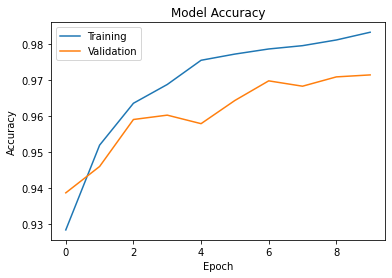

0.9713734984397888

In [69]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
history.history['accuracy'][-1]
history.history['val_accuracy'][-1]


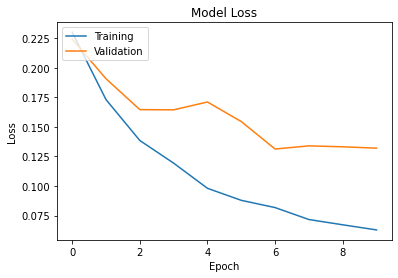

In [70]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [30]:
# Final evaluation of the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("t8/cp.ckpt")
scores = model.evaluate(X_test_trunc, y_test_oh, verbose=1,batch_size = 256)
print("Accuracy: %.2f%%" % (scores[1]*100))

207/207 [==============================] - 49s 225ms/step - loss: 0.2304 - accuracy: 0.9517s - loss: 0.2303 - 
Accuracy: 95.15%


In [52]:
#model.get_weights()

[4 4 3 ... 4 4 4]
[4 4 3 ... 4 4 4]
Confusion matrix, without normalization


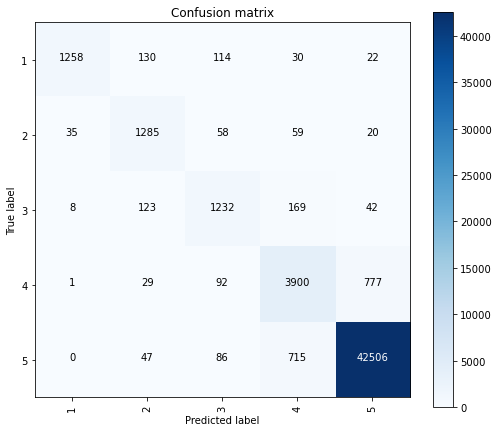

In [22]:
# Function for confusion matrix
classes=[1,2,3,4,5]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test_trunc);
cnf_matrix = confusion_matrix(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1))
print(np.argmax(y_test_oh, axis=1))
print(np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)

plot_confusion_matrix(cnf_matrix, classes, normalize=False,
                      title='Confusion matrix')

In [73]:
# Print evaluation metrics
from sklearn import metrics
print(metrics.classification_report(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1), target_names=('1','2','3','4','5')))

              precision    recall  f1-score   support

           1       0.97      0.81      0.88      1554
           2       0.80      0.88      0.84      1457
           3       0.78      0.78      0.78      1574
           4       0.80      0.81      0.81      4799
           5       0.98      0.98      0.98     43354

    accuracy                           0.95     52738
   macro avg       0.86      0.85      0.86     52738
weighted avg       0.95      0.95      0.95     52738



In [31]:
# View actual and predicted label
text_labels = le.classes_
for i in range(100):
    prediction = model.predict(np.array([X_test_trunc[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print('Review:  '+X_test.iloc[i])
    print('Actual label: ' + y_test.iloc[i])
    print("Predicted label: " + predicted_label)
    print('')

Review:  very professional  thorough
Actual label: 5
Predicted label: 5

Review:  awesome as usual 
Actual label: 5
Predicted label: 5

Review:  overall  the visit was ok  
Actual label: 4
Predicted label: 4

Review:  so lovely  personable  kind  attentive i was blown away at her attention to detail and thoroughness so excited to have found her
Actual label: 5
Predicted label: 5

Review:  very informative and helpful
Actual label: 5
Predicted label: 5

Review:  amazing doctor that really cares and takes time with patients 
Actual label: 5
Predicted label: 5

Review:  he was very nice and friendly doctor only thing that was not good was when i got the office they said he was a specialist so my copay will be 40 i had bad cough and did a research for primary care doctor and found his name on zocdoc i told the receptionist that i didnt need to see a kidney specialist that was his speciality at the end  they said i just needed to pay regular copay i told them that they need to correct their